# DecomposeRey_FoverH_tiles_v1.py
The shoaling of MLD due to ice melt should have some impact on the density of energy coming from the atmosphere, but not easy to demonstrate. So this script tries to decompose this term to see if we can identify this amplification.
To do so, we use a Reynolds decomposition of the heat flux entering the mixed layer $\mathcal{Q}_{surf}=\frac{1}{\rho_0 c_p} \frac{F}{H}$ (in the manuscript). 

A Reynolds decomposition consists in writing that a quantity $X$ can be decomposed into $X = \overline{X} + X'$ with $\overline{X}$ a slow-varying part of $X$ (typically a time average or, as in this case, a climatology) and $X'$ the fast fluctuations around that slow-varying state.  

BR, 10/02/2023

v1: Revamped for publication

In [1]:
import xarray as xr
import proplot as pplt
import numpy as np
import pandas as pd
from pathlib import Path
xr.set_options(keep_attrs=True)
pplt.rc['figure.facecolor'] = 'white'

In [2]:
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = SGECluster(
    queue="compute",
    cores=30,          # Total number of cores per job
    processes=5,        # Cores/processes = threads/worker
    walltime="12:00:00",
    memory="250GB",    # Total amount of memory per job
    local_directory="~/Projects/SiberianHW/src/dask-worker-space/",
    scheduler_options={
        "dashboard_address": ":7880",
    },
)

cluster.scale(jobs=5)          # Number of workers
client = Client(cluster)    # Connect to that cluster
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SGECluster
Dashboard: /proxy/7880/status,
Dashboard: /proxy/7880/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://129.173.118.14:33403,Workers: 0
Dashboard: /proxy/7880/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Mathematical perspective
Following former analysis from the other `Decompose_QoverH_HB_.py` script, the best way to decompose the Q over H term is the following:
$$\frac{F}{H}=(\overline{F}+F')\left(\overline{\frac{1}{H}}+\left(\frac{1}{H}\right)'\right) \\
=\overline{F}\overline{\frac{1}{H}} + \overline{F}\left(\frac{1}{H}\right)' + F' \overline{\frac{1}{H}} + F' \left(\frac{1}{H}\right)'$$

Using a Teylor decomposition to move the $\frac{1}{H}$ term on the numerator also works, but leads to some residuals that are less easy to justify, though small enough to give the same picture. 
Also, good to keep in mind that $\overline{fg}=\overline{f} \overline{g} + \overline{f'g'}$ meaning that:
$$\overline{\frac{F}{H}} = \overline{F} \overline{\frac{1}{H}} + \overline{F' \left(\frac{1}{H}\right)'}$$

### Predefined function 

In [3]:
def smoothedClima_mhw(ds):
    """Replicate the climatology calculation used in the marineHeatWave.py algorithm."""
    if ~np.isin("time",ds.dims):
        print("No 'time' dimensions in the dataset")
        return
    # Calculate a rolling mean first, with a 11 days window. 
    ds_rolled = ds.rolling(time=11, min_periods=1, center=True).mean()
    # Calculate the mean over dayofyear
    ds_clim_doy = ds_rolled.groupby("time.dayofyear").mean()
    # If I just smooth over that, my beginning and end will be weird.
    # A solution is to replicate 3 times, do the running average, and get the middle year.
    stackedClim = xr.concat([ds_clim_doy,ds_clim_doy,ds_clim_doy],dim='year').stack(time={'year','dayofyear'})
    # Smooth the time series
    smoothedClim = stackedClim.rolling(time=31, 
                                       min_periods=1,
                                       center=True).mean()
    # Restrain the middle year and rearrange the dimensions to only keep "dayofyear"
    tmpSmooClim = smoothedClim.where(smoothedClim.year==1,drop=True).drop('year')
    ds_smoothedClim = tmpSmooClim.rename({'time':'dayofyear'}).assign_coords(dayofyear=ds_clim_doy.dayofyear.data)
    return ds_smoothedClim

## Process
In order to calculate those terms, we need to:
* Upload the surface heat flux (from grid_T_2D.qt) and the MLD
* Average those terms over the area of the tiles
* Calculate the climatology and the anomaly
* Calculate the respective terms in the last equation
* Compare the sum of the terms (divided by $\rho_0 c_p$) to the actual surface flux term
* Then finally look at the results.

#### Load the data
Load the MLD and the total and solar heat fluxes Qt and Qsr 

In [12]:
#Paths
path2figs = PathHome.joinpath("Projects/SiberianHW/figures/")
path2proc = PathHome.joinpath("Projects/SiberianHW/data/processed/")
path2qt = PathHome.joinpath("Projects/SiberianHW/data/interim/tiles/")

In [13]:
# Load the MLD and qt for all tiles
ds_forc_tiles = xr.open_dataset(path2proc.joinpath('Forc_tiles_3Oceans.nc'))
ds_MLD_tiles = xr.open_dataset(path2proc.joinpath('MLD_tiles_3Oceans.nc'))
# Load Ice Properties for tiles
ds_Ice = xr.open_dataset(path2proc.joinpath('IceProp_tiles_3Oceans.nc')).drop('month')
ds_Ice['fmmflx'] = ds_Ice.fmmflx  * 86400
ds_Ice.fmmflx.attrs['Units'] = "kg m$^{-2}$ d$^{-1}$"

We will need to compare the results with the heatwaves. To do so, need to load the data.

In [14]:
# Load Mixed Layer temperature
ds_MLT =  xr.open_dataset(path2proc.joinpath('MLT_tiles_3Oceans.nc'))
# Load metrics of MHWs
ds_mhws_filter =  xr.open_dataset(path2proc.joinpath('MHWfiltMean0.1_DetectionProperties_TiledMLT.nc'))
ds_mhws_filter = ds_mhws_filter.assign_coords({'tiles':('tiles',ds_MLT.tiles.data)})
# Load climatology and threshold for all tiles
ds_clims =  xr.open_dataset(path2proc.joinpath('ClimThreshSmooth_MLT_Tiled3O.nc'))
ds_clims = ds_clims.assign_coords(time=('index',ds_MLT.time.data)).swap_dims({'index':'time'}).drop('index')
# Also load the integrated MHW drivers
ds_mhw_attr =  xr.open_dataset(path2proc.joinpath('IntegratedHBTerms_forMHWAttribution.nc'))

#### Calculate the penetrating solar radiations
Some of the radiations go below the MLD, and therefore do not impact the heat budget in the mixed layer. They need to be removed from the Qt. To calculate them, I use the NEMO parametrization.

In [15]:
# Parameters extracted from NEMO (trc_oce_rgb or something like that)
CoefAtt = [0.02501, 0.07866, 0.38189] # Attenuation Coefficients for RGB wavelengths
R0 = 0.58 # Percentage of non-penetrating SW radiation (wavelengths outside RGB)
ksi0 = 1/0.35 # Attenuation coefficient for non-penetrating wavelengths
# Calculate the percentage that penetrates deeper than MLD
RGBAtt = (1-R0)/3 * (np.exp(-ds_MLD_tiles*CoefAtt[0]) + np.exp(-ds_MLD_tiles*CoefAtt[1]) + np.exp(-ds_MLD_tiles*CoefAtt[2]))
AttNonePen = R0 * np.exp(-ds_MLD_tiles*ksi0)
# Convert units of Qsr from W/m2 to degreeC/m3/s
Qsr_surf = (ds_forc_tiles.qsr)
Qsr_belowMLD = (Qsr_surf * (RGBAtt + AttNonePen)).rename({'MLD':'Qsr_below'})
# Now can remove this part of the solar radiations from the heatflux
Qt_mld = ds_forc_tiles.qt - Qsr_belowMLD.Qsr_below

#### Calculate climatology and anomalies
Calculate a climatology using a 11 days rolling window. I could had a 31 days smoothing filter, to get the same as for the heat budget decomposition, but I will keep it simple for now. I calcualte the climatology and anomalies for the $Qt_{mld} = Qt-Qsr$, the MLD and the $\frac{1}{MLD}$ to match the decomposition.

In [16]:
# Create a inverse of MLD, for the decomposition
ds_1ovrMLD = 1 / ds_MLD_tiles.MLD
# Calculate climatology for the heat flux entering the mixed layer, the MLD and the inverse MLD.
# This is the $\overline{x}$
Climato_Qt_mld = smoothedClima_mhw(Qt_mld)
Climato_MLD = smoothedClima_mhw(ds_MLD_tiles)
Climato_1ovrMLD = smoothedClima_mhw(ds_1ovrMLD)
# Calculate Anomalies by removing climatology. This is the $X'$
Anom_Qt_mld = Qt_mld.groupby("time.dayofyear") - Climato_Qt_mld
Anom_MLD = ds_MLD_tiles.groupby("time.dayofyear") - Climato_MLD
Anom_1ovrMLD = ds_1ovrMLD.groupby("time.dayofyear") - Climato_1ovrMLD

#### Now calculate the four terms
Use the above mentioned decomposition $$\frac{F}{H} = \overline{F}\overline{\frac{1}{H}}  + F' \overline{\frac{1}{H}} + \overline{F}\left(\frac{1}{H}\right)' + F' \left(\frac{1}{H}\right)'$$ 
Calculate each of those terms.

In [19]:
# Calculate the four terms:
# LHS: Q/H
QoverH = Qt_mld / ds_MLD_tiles.MLD
QoverH = QoverH.rename('QovrH')
# RHS 1: \overline{F} * \overline{1/H}
Qbar_1ovrHbar = xr.ones_like(Qt_mld).groupby('time.dayofyear') * (Climato_Qt_mld * Climato_1ovrMLD)
Qbar_1ovrHbar = Qbar_1ovrHbar.rename('Qbar_1ovrHbar')
# RHS 2: F' * \overline{1/H}
Qprime_1ovrHbar = Anom_Qt_mld.groupby("time.dayofyear") * Climato_1ovrMLD
Qprime_1ovrHbar = Qprime_1ovrHbar.rename('Qprime_1ovrHbar')
# RHS 3: \overline{F} * (1/H)'
Qbar_1ovrHprime = Anom_1ovrMLD.groupby("time.dayofyear") * Climato_Qt_mld
Qbar_1ovrHprime = Qbar_1ovrHprime.rename('Qbar_1ovrHprime')
# RHS 1: F' * (1/H)'
Qprime_1overHprime = Anom_1ovrMLD * Anom_Qt_mld
Qprime_1overHprime = Qprime_1overHprime.rename('Qprime_1ovrHprime')
# Calculate the residuals, to make sure my decomposition is closed:
Residual_Reynolds = QoverH - (Qbar_1ovrHbar + Qprime_1ovrHbar + Qbar_1ovrHprime + Qprime_1overHprime)
Residual_Reynolds = Residual_Reynolds.rename('Residual_Reynolds')
# After check, the residuals are really just numericla noise (<1e-15)! So really good!
# Merge everything together in one dataset
ds_QovrH_rey = xr.merge([QoverH, Qbar_1ovrHbar, Qprime_1ovrHbar, Qbar_1ovrHprime, Qprime_1overHprime, Residual_Reynolds])

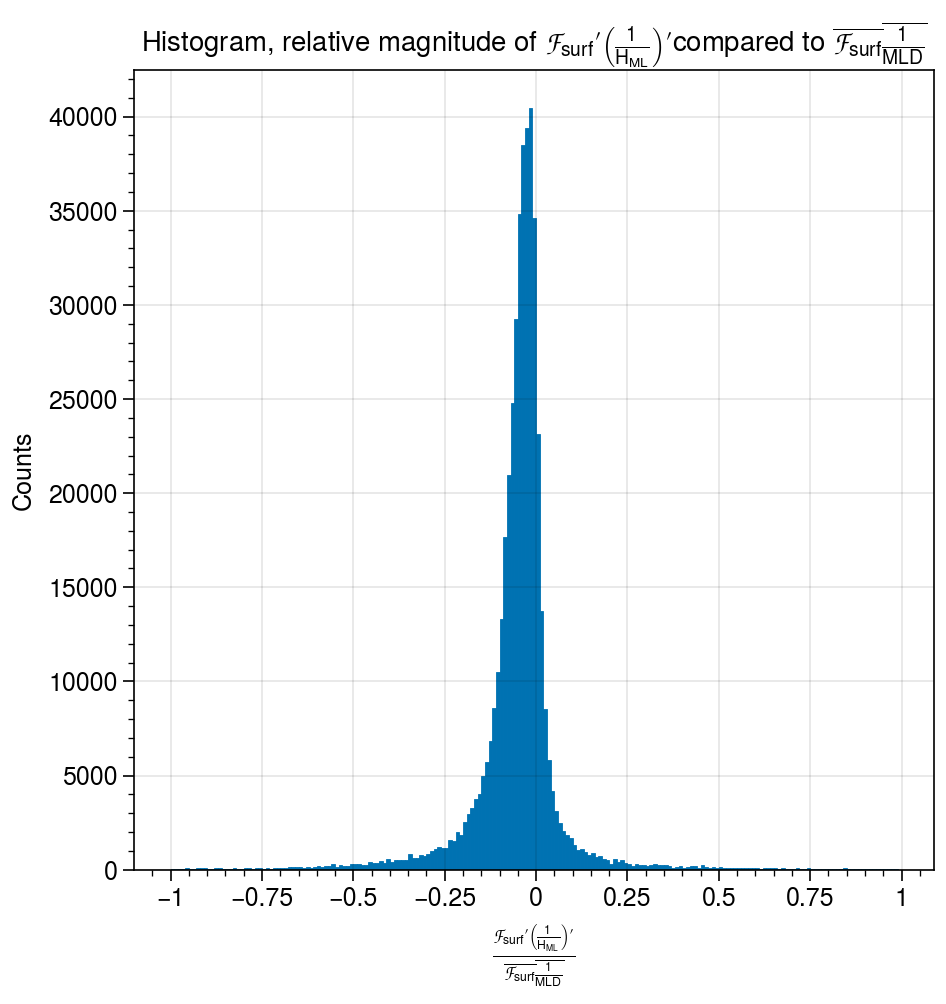

In [31]:
# Need to further decompose this last term into clim+anomaly, since it is a covariance
# Get climatology of F' * (1/H)' and broadcast it to have the right size
Qprime_1overHprime_bar = xr.ones_like(Qt_mld).groupby('time.dayofyear') * smoothedClima_mhw(Qprime_1overHprime)
Qprime_1overHprime_bar = Qprime_1overHprime_bar.rename('Qprime_1overHprime_bar')
# Remove climatology to get anomalies
Qprime_1overHprime_prime = Qprime_1overHprime - Qprime_1overHprime_bar
Qprime_1overHprime_prime = Qprime_1overHprime_prime.rename('Qprime_1overHprime_prime')

# Plot it to see if it can be neglected
fig, ax = pplt.subplots(axwidth=4)
_ = (Qprime_1overHprime_bar/Qbar_1ovrHbar).plot.hist(bins=np.arange(-1,1,0.01), ax=ax)#.plot(vmin=-0.1,vmax=0.1)
ax[0].format(
    xlabel=r"$\frac{\mathcal{F}_{surf}\prime \left(\frac{1}{H_{ML}}\right)\prime}{\overline{\mathcal{F}_{surf}}\overline{\frac{1}{MLD}}}$",
    ylabel='Counts',
    title=r"Histogram, relative magnitude of $\mathcal{F}_{surf}\prime \left(\frac{1}{H_{ML}}\right)\prime$"+\
             r"compared to $\overline{\mathcal{F}_{surf}}\overline{\frac{1}{MLD}}$")

### Plot Specific event
Now we can make sure that the decomposition is useful by investigating specific events, particularly the Siberian Heatwave from Summer 2020.

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


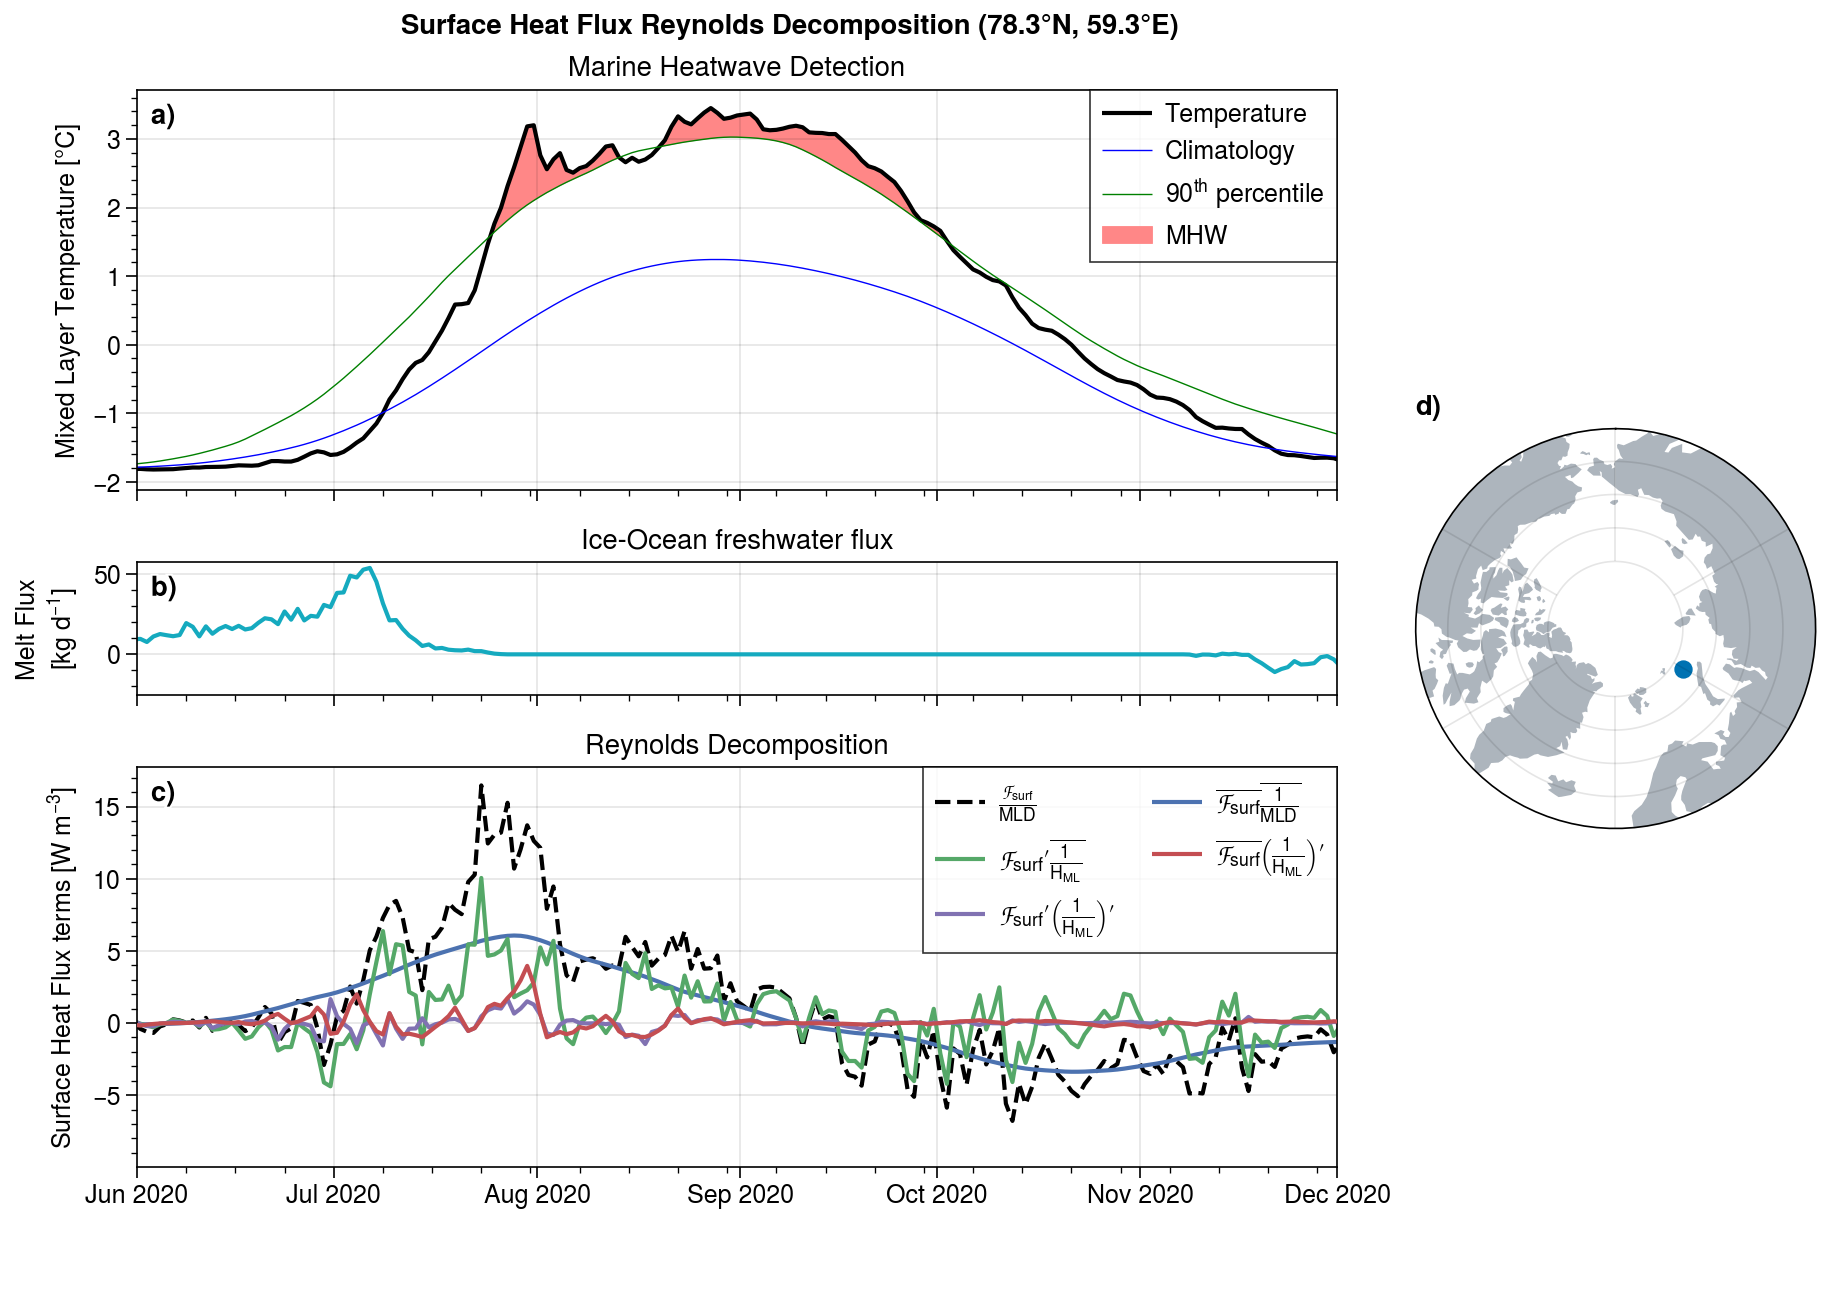

In [20]:
# Select tile and year
tt=50
yy='2020'
# Create plot
fig = pplt.figure(axwidth=6,axheight=2,sharey=0, sharex=3)
axs = fig.subplots([[1,1,1,0],[2,2,2,0],[3,3,3,0]],hratios=(3,1,3))
# First panel: MLT, climatology, threshold, MHW.
h0=axs[0].plot(ds_MLT.toce.isel(tiles=tt),c='k',label='Temperature')
h1=axs[0].plot(ds_clims.seas.isel(tiles=tt),c='b',lw=0.5, label='Climatology')
h2=axs[0].plot(ds_clims.thresh.isel(tiles=tt),c='g',lw=0.5, label='90$^{th}$ percentile')
h3,h4=axs[0].area(ds_MLT.time,ds_clims.thresh.isel(tiles=tt),ds_MLT.toce.isel(tiles=tt),
            negpos=True, negcolor='w',poscolor='red4',label='MHW')
axs[0].legend([h0,h1,h2,h4],ncol=1)
axs[0].format(ylabel='Mixed Layer Temperature [°C]',
              title='Marine Heatwave Detection',
              suptitle="Surface Heat Flux Reynolds Decomposition ({0:.1f}°N, {1:.1f}°E){2}".format(
                  ds_MLD_tiles.isel(tiles=tt).latitude.values, ds_MLD_tiles.isel(tiles=tt).longitude.values,
                  "                                                 ") #SOOOOO ugly... But centers the title.
             )
# Second panel: Freezing-melting flux, to see when the shoaling shouold start.
axs[1].plot(-ds_Ice.fmmflx.isel(tiles=tt), c='cyan6',ls='-')
axs[1].format(ylabel='Melt Flux\n[kg d$^{-1}$]',
              title='Ice-Ocean freshwater flux'
             )
# Third panel: Plot Reynold decomposition
cyc = pplt.Cycle('seaborn')
hs4=axs[2].plot(ds_QovrH_rey.QovrH.isel(tiles=tt),c='k',ls='--',
                label=r'$\frac{\mathcal{F}_{surf}}{MLD}}$') # Full heat flux term
# First RHS term (bar bar)
hs0=axs[2].plot(ds_QovrH_rey.Qbar_1ovrHbar.isel(tiles=tt),
                cycle='seaborn',
                label=r'$\overline{\mathcal{F}_{surf}}\overline{\frac{1}{MLD}}$') 
# Second RHS term (prime bar)
hs1=axs[2].plot(ds_QovrH_rey.Qprime_1ovrHbar.isel(tiles=tt),
                label=r"$\mathcal{F}_{surf}\prime \overline{\frac{1}{H_{ML}}}$")
# Third RHS term (bar prime)
hs2=axs[2].plot(ds_QovrH_rey.Qbar_1ovrHprime.isel(tiles=tt),zorder=10,
                label=r"$\overline{\mathcal{F}_{surf}}\left(\frac{1}{H_{ML}}\right)\prime$")
# Fourth RHS term (prime prime)
hs3=axs[2].plot(ds_QovrH_rey.Qprime_1ovrHprime.isel(tiles=tt),
                label=r"$\mathcal{F}_{surf}\prime \left(\frac{1}{H_{ML}}\right)\prime$")
# Add legend and format panel
axs[2].legend([hs4,hs0,hs1,hs2,hs3], ncol=2)
axs[2].format(xrotation=0, xformatter='%b %Y',
              xlim=[np.datetime64(yy+'-06'),np.datetime64(yy+'-12')],
              ylabel='Surface Heat Flux terms [W m$^{-3}$]',
              xlabel='',
              title='Reynolds Decomposition'
             )
# Format figure
axs.format(abc='a)',abcloc='ul')
# Fourth panel: Map of location of tile
proj=pplt.Proj('nplaea')
ax_end = fig.subplot(1,4,(4), projection=proj,abc='a)',number=4)
ax_end.scatter(ds_MLD_tiles.isel(tiles=tt).longitude.values, 
               ds_MLD_tiles.isel(tiles=tt).latitude.values, 
               )
ax_end.format(boundinglat=60, land=True, landcolor='grey5', 
             )
# fig.suptitle("Surface Heat Flux Reynolds Decomposition ({0:.1f}°N, {1:.1f}°E)".format(
#     ds_MLD_tiles.isel(tiles=tt).latitude.values, 
#     ds_MLD_tiles.isel(tiles=tt).longitude.values))

##  Need some statistical approach
Need to complement this nice specific view by a broader, more statistical approach. Too many tiles to go one by one. It is difficult to find when the `Qbar_1ovrHprime` term becomes important. We can try to integrate each of the 4 terms and the Q/H for each MHW onset and decay and look at there relative importance, as we do for the HB terms. Hopefully, this could provide some generic insight on the role of that feedback.

Basically, we use the above decomposition, then integrate over the onset (or decay), then normalize and rank.
$$\int_{start}^{peak}\frac{Q}{H} = \int \overline{Q}\overline{\frac{1}{H}}  + \int Q' \overline{\frac{1}{H}} + \int \overline{Q}\left(\frac{1}{H}\right)' + \int Q' \left(\frac{1}{H}\right)'$$ 
$$\iff 1 = \frac{1}{\int \frac{Q}{H}} \left(\int \overline{Q}\overline{\frac{1}{H}}  + \int Q' \overline{\frac{1}{H}} + \int \overline{Q}\left(\frac{1}{H}\right)' + \int Q' \left(\frac{1}{H}\right)' \right)$$ 

In [22]:
# Initialize dictionary to save loop resutls
tempdict1 = {}
tempdict2 = {}
# Loop over tiles
for ind,tile in enumerate(ds_mhws_filter.tiles):
    # Initialize some dataframe to store data
    df_QovrH_onset = pd.DataFrame()
    df_QovrH_decaY = pd.DataFrame()
    # Select Reynolds decomposition for this tile
    ds_QovrH_rey_tile = ds_QovrH_rey.isel(tiles=ind)
    # Loop over MHW
    for ind2, nmhw in enumerate(ds_mhws_filter.mhw):
        # Find start, peak and end indices
        StartHW = ds_mhws_filter.index_start.sel(tiles=tile,mhw=nmhw).astype('int')
        PeakHW = ds_mhws_filter.index_peak.sel(tiles=tile,mhw=nmhw).astype('int')
        EndHW = ds_mhws_filter.index_end.sel(tiles=tile,mhw=nmhw).astype('int')
        # Select the onset
        MHWonset_QovrH = ds_QovrH_rey_tile.isel(time=slice(StartHW.values,PeakHW.values+1))
        # Integrate (sum) over the onset, then convert to DataArray
        MHWonset_QovrH_sum = MHWonset_QovrH.sum(dim='time',min_count=1).to_array().rename({'variable':'ReynoldsDec'})
        # Convert the DataArray to a data frame and append it to the initialized dataframe
        df_QovrH_onset[ind2] = MHWonset_QovrH_sum.to_dataframe(name='mhw').mhw
        # Same strategy for decay
        MHWdecay_QovrH = ds_QovrH_rey_tile.isel(time=slice(PeakHW.values,EndHW.values+1))
        MHWdecay_QovrH_sum = MHWdecay_QovrH.sum(dim='time',min_count=1).to_array().rename({'variable':'ReynoldsDec'})
        df_QovrH_decaY[ind2] = MHWdecay_QovrH_sum.to_dataframe(name='mhw').mhw
    # Convert the dataframe to a DataArray and put in the dict. There must be a better, more pyhton-esque way....
    tempdict1[ind] = xr.DataArray(df_QovrH_onset.transpose()).rename({'dim_0':'mhw'})
    tempdict2[ind] = xr.DataArray(df_QovrH_decaY.transpose()).rename({'dim_0':'mhw'})
# Finally, concatenate all dictionary items into one Dataset (for onset and decay first, then merge both).
ds_QovrH_onset = xr.concat(list(tempdict1.values()),pd.Index(ds_QovrH_rey.tiles, name="tiles")).to_dataset(dim="ReynoldsDec")
ds_QovrH_decaY = xr.concat(list(tempdict2.values()),pd.Index(ds_QovrH_rey.tiles, name="tiles")).to_dataset(dim="ReynoldsDec")
ds_QovrH_mhw = xr.concat([ds_QovrH_onset,ds_QovrH_decaY],pd.Index(['Onset','Decay'], name="trend"))
print('Done')
# Some descriptions before saving 
ds_QovrH_mhw.attrs['Description'] = "Integration of the Q over H Reynolds Decomposition over Marine Heatwaves onset and decay. "\
    +"MHW are detected with Marine Heatwaves Algorithm and filtered for peak intensity above -1.5°C "\
    +"(MHWfilt1.5_DetectionProperties_TiledMLT.nc). "\
    +"The Reynolds decomposition is applied to Qt-Qsr_{mld} and to 1/MLD, and expanded to provide 4 terms."\
    +"Integration of peak value is both in onset and decay."
ds_QovrH_mhw.attrs['Units'] = "W m^{-3}"
ds_QovrH_mhw.attrs['Source'] = "Made with Decompose_tiledQoverH.py script, by BR, 13/02/2023"
# ds_mhw_attr.to_netcdf(Path2proc.joinpath("IntegratedQovrHDecompo_forFeedback.nc"))

Done


In [23]:
# Rank MHW drivers, as in the `Analyse_MHWDrivers_Tiles_v1.py` script
# We will neglect the residuals for now. We know they don't impact the story.
# First divide the heat budget terms by the tendency
HBTerms_norm1 = ds_mhw_attr/ ds_mhw_attr.Tendency_top
# Onset
mhw_normDrv1_Onset=HBTerms_norm1.sel(trend='Onset').drop_vars(['Tendency_top','trend','Resi_top'])
df_mhw_normDrv1_Onset = mhw_normDrv1_Onset.to_dataframe(dim_order=('tiles','mhw')).dropna()
# Decay
mhw_normDrv1_Decay=HBTerms_norm1.sel(trend='Decay').drop_vars(['Tendency_top','trend','Resi_top'])
df_mhw_normDrv1_Decay = mhw_normDrv1_Decay.to_dataframe(dim_order=('tiles','mhw')).dropna()
# Then Rank the processes
df_rankDrv1_Onset = df_mhw_normDrv1_Onset.rank(axis=1,ascending=False)
df_rankDrv1_Decay = df_mhw_normDrv1_Decay.rank(axis=1,ascending=False)

In [24]:
# We want to focus on MHWs that are driven by surface heat flux, since that is the heart of the research question.
# Select MHWs whose primary process is the surface heat flux.
ds_QovrH_mhw_filt = ds_QovrH_mhw.where(xr.Dataset.from_dataframe(df_rankDrv1_Onset).Qsr_net_top == 1)

Do something similar for the Reynolds decomposition terms. Normalize the integrated terms, then rank them.

In [27]:
# Normalize the terms
QovHAnom_mhw = (ds_QovrH_mhw_filt.QovrH-ds_QovrH_mhw_filt.Qbar_1ovrHbar)
nQovrH_mhw = (ds_QovrH_mhw_filt / QovHAnom_mhw).drop(['QovrH','Residual_Reynolds','Qbar_1ovrHbar'])
# Onset
# Convert to dataframe
df_nQovrH_onset = nQovrH_mhw.sel(trend='Onset',drop=True).to_dataframe(dim_order=('tiles','mhw'))
# Rank terms
df_nQovrH_onset_rank = df_nQovrH_onset.rank(axis=1,ascending=False)
# Decay
df_nQovrH_decay = nQovrH_mhw.sel(trend='Decay',drop=True).to_dataframe(dim_order=('tiles','mhw'))
df_nQovrH_decay_rank = df_nQovrH_decay.rank(axis=1,ascending=False)

Let's give a quick look at the primary driver proportions for the selected MHWs.

In [28]:
df_nQovrH_onset_rank.where(df_nQovrH_onset_rank==1).count()/ df_nQovrH_onset_rank.count()[0] *100

Qprime_1ovrHbar      88.48
Qbar_1ovrHprime      10.72
Qprime_1ovrHprime     0.80
dtype: float64

In [29]:
df_nQovrH_decay_rank.where(df_nQovrH_decay_rank==1).count() /df_nQovrH_decay_rank.count()[0] *100

Qprime_1ovrHbar      75.84
Qbar_1ovrHprime      21.76
Qprime_1ovrHprime     2.40
dtype: float64

### Spatial distribution 
The next step is to look at the spatial distribution of those drivers. 

In [17]:
# Some pre-defined metrics
CoordsT = ds_QovrH_rey[['latitude','longitude']] # Number of MHW per tiles
MHWs_tile = df_nQovrH_onset_rank.dropna().groupby('tiles').size() # Number of MHW per tiles
# Onset
MHWsperTile_QprHbar1_Onset = df_nQovrH_onset_rank.where(df_nQovrH_onset_rank.Qprime_1ovrHbar==1).dropna().groupby('tiles').size()
MHWsperTile_QprHbar1_Onset = (MHWsperTile_QprHbar1_Onset/MHWs_tile).dropna()
Coords_Onset_QprHbar1 = CoordsT.sel(tiles=MHWsperTile_QprHbar1_Onset.index)
MHWsperTile_QbarHpr1_Onset = df_nQovrH_onset_rank.where(df_nQovrH_onset_rank.Qbar_1ovrHprime==1).dropna().groupby('tiles').size()
MHWsperTile_QbarHpr1_Onset = (MHWsperTile_QbarHpr1_Onset/MHWs_tile).dropna()
Coords_Onset_QbarHpr1 = CoordsT.sel(tiles=MHWsperTile_QbarHpr1_Onset.index)
MHWsperTile_QprHpr1_Onset = df_nQovrH_onset_rank.where(df_nQovrH_onset_rank.Qprime_1ovrHprime==1).dropna().groupby('tiles').size()
MHWsperTile_QprHpr1_Onset = (MHWsperTile_QprHpr1_Onset/MHWs_tile).dropna()
Coords_Onset_QprHpr1 = CoordsT.sel(tiles=MHWsperTile_QprHpr1_Onset.index)
# Decline
MHWsperTile_QprHbar1_Decay = df_nQovrH_decay_rank.where(df_nQovrH_decay_rank.Qprime_1ovrHbar==1).dropna().groupby('tiles').size()
MHWsperTile_QprHbar1_Decay = (MHWsperTile_QprHbar1_Decay/MHWs_tile).dropna()
Coords_Decay_QprHbar1 = CoordsT.sel(tiles=MHWsperTile_QprHbar1_Decay.index)
MHWsperTile_QbarHpr1_Decay = df_nQovrH_decay_rank.where(df_nQovrH_decay_rank.Qbar_1ovrHprime==1).dropna().groupby('tiles').size()
MHWsperTile_QbarHpr1_Decay = (MHWsperTile_QbarHpr1_Decay/MHWs_tile).dropna()
Coords_Decay_QbarHpr1 = CoordsT.sel(tiles=MHWsperTile_QbarHpr1_Decay.index)
MHWsperTile_QprHpr1_Decay = df_nQovrH_decay_rank.where(df_nQovrH_decay_rank.Qprime_1ovrHprime==1).dropna().groupby('tiles').size()
MHWsperTile_QprHpr1_Decay = (MHWsperTile_QprHpr1_Decay/MHWs_tile).dropna()
Coords_Decay_QprHpr1 = CoordsT.sel(tiles=MHWsperTile_QprHpr1_Decay.index)

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instant

Text(0.5, 0.98, 'Location of MHWs dominated by:')

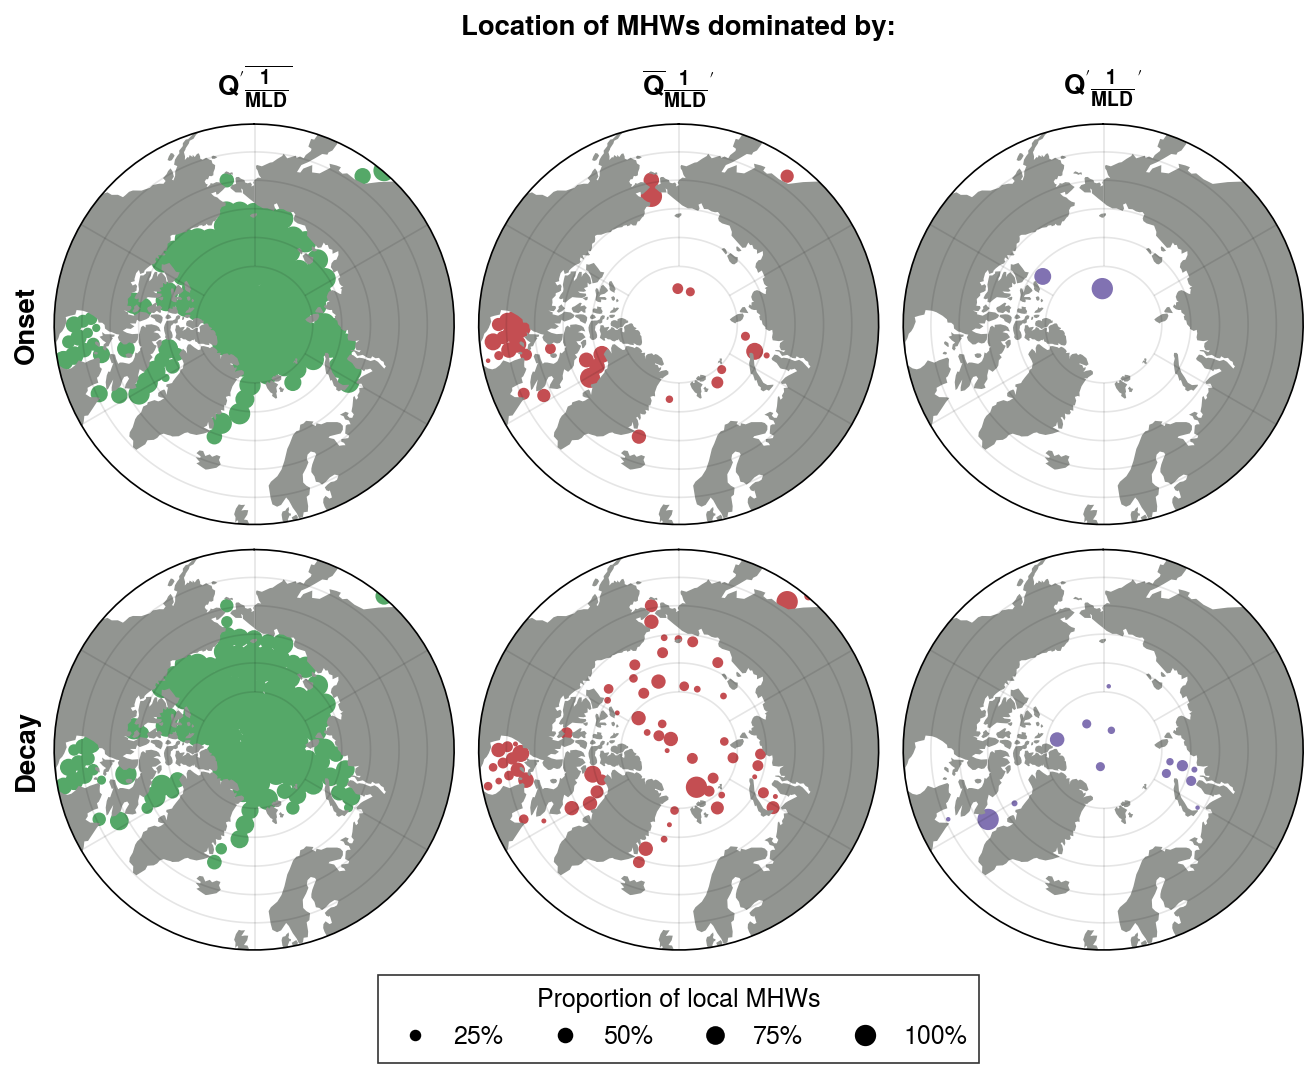

In [17]:
# Plot all of that
fig,axs = pplt.subplots(nrows=2,ncols=3,proj=proj,refwidth=2)
cycleQH=pplt.get_colors(pplt.Cycle('seaborn',N=4))
sc=axs[0].scatter(Coords_Onset_QprHbar1.longitude, Coords_Onset_QprHbar1.latitude,
                  s=MHWsperTile_QprHbar1_Onset*100, c=cycleQH[1],
                  smin=0, smax=50,)
axs[1].scatter(Coords_Onset_QbarHpr1.longitude, Coords_Onset_QbarHpr1.latitude,
               s=MHWsperTile_QbarHpr1_Onset*100, c=cycleQH[2],
                  smin=0, smax=50)
axs[2].scatter(Coords_Onset_QprHpr1.longitude, Coords_Onset_QprHpr1.latitude,
               s=MHWsperTile_QprHpr1_Onset*100, c=cycleQH[3],
                  smin=0, smax=50)
axs[3].scatter(Coords_Decay_QprHbar1.longitude, Coords_Decay_QprHbar1.latitude,
               s=MHWsperTile_QprHbar1_Decay*100, c=cycleQH[1],
                  smin=0, smax=50)
axs[4].scatter(Coords_Decay_QbarHpr1.longitude, Coords_Decay_QbarHpr1.latitude,
               s=MHWsperTile_QbarHpr1_Decay*100, c=cycleQH[2],
                  smin=0, smax=50)
axs[5].scatter(Coords_Decay_QprHpr1.longitude, Coords_Decay_QprHpr1.latitude,
               s=MHWsperTile_QprHpr1_Decay*100, c=cycleQH[3],
                  smin=0, smax=50)
axs.format(boundinglat=55, land=True, landcolor='grey', 
           toplabels=[r"$Q'\overline{\frac{1}{MLD}}$", r"$\overline{Q}\frac{1}{MLD}'$" , r"$Q'\frac{1}{MLD}'$"],
           leftlabels=['Onset','Decay']
          )
fig.legend(*sc.legend_elements("sizes", num=4,func=lambda s: s*2, fmt=pplt.PercentFormatter()),
           loc='b', title='Proportion of local MHWs', ncol=4
          )#, fmt='%1.1f%%'))
fig.suptitle("Location of MHWs dominated by:")

Not very conclusive.

The ranking has clear limitations. The influence of the shoaling is not often the primary driver. But that is actually a reasonable result: we should actually expect the "feedback" to need an important initial atmospheric energy input to start melting the ice, before the shoaling kicks in. So the heat flux anomaly $F' \overline{\frac{1}{H}}$ should be the first term and the shoaling anomaly $\overline{F} \left(\frac{1}{H}\right)'$ should be a secondary driver.

## Impact on prolonging MHWs
Let's dig a bit further in the analysis. Let's attempt to pinpoint if the $\overline{F_{surf}} \left( \frac{1}{H_{ml}}\right)^\prime$ could play a role in prolonging MHWs. To do so, we start with the special case of the Siberian MHW, as illustrated in the Manuscript. We find the tile and MHW number, look at the intensity of the term, remove that from the temperature tendency, and see if that's enough to make it go below threshold.

Then look at a more general perspective, reproducing the analysis for all MHWs of interest.

In [32]:
# First check the Siberian MHW
# Select tile and MHW; define rho and c_p
tt, mhw = 50, 14
rho, cp = 1026, 3991.86795711963
# Select MLT, climatology and MLD for the tile
MLT_SibHW = ds_MLT.toce.isel(tiles=tt).compute()
clim_SibHW = ds_clims.isel(tiles=tt).compute()
MLD_SibHW = ds_MLD_tiles.isel(tiles=tt).compute()
# Need to convert the Q flux in °C per day
QovrH_SibHW_inC = ds_QovrH_rey.isel(tiles=tt) / (rho * cp) * 86400
QovrH_3pr_SibHW2020_intC = Qprime_1overHprime_prime.isel(tiles=tt) / (rho * cp) * 86400

In [33]:
# Next step is to integrate the flux, to actually have the same units.
# We integrate from the start date of the MHW
# First MHW of the SibHW
# Get start and end dates
DateStart1, DateEnd1 = ds_mhws_filter.isel(tiles=tt,mhw=mhw).date_start, ds_mhws_filter.isel(tiles=tt,mhw=mhw+1).date_end
# Select MLT and Reynolds decomposition terms during MHW
MLT_SibHW2020_1 = MLT_SibHW.sel(time=slice(DateStart1, DateEnd1+np.timedelta64(1,'D')))
QovrH_SibHW2020_1 = QovrH_SibHW_inC.sel(time=slice(DateStart1, DateEnd1+np.timedelta64(1,'D')))
QovrH_3pr_SibHW2020_1 = QovrH_3pr_SibHW2020_intC.sel(time=slice(DateStart1, DateEnd1+np.timedelta64(1,'D')))
# Do a Cumulative Integral of ReyDec terms during the MHW
QovrH_SibHW2020_int_1 = QovrH_SibHW2020_1.cumsum()
QovrH_3pr_SibHW2020_int_1 = QovrH_3pr_SibHW2020_1.cumsum()
# Remove those cumulative integrals from the MLT.
MLT_1_noShoal1 = MLT_SibHW2020_1 - QovrH_SibHW2020_int_1.Qbar_1ovrHprime
MLT_1_noShoal2 = MLT_SibHW2020_1 - QovrH_SibHW2020_int_1.Qbar_1ovrHprime - QovrH_3pr_SibHW2020_int_1
# Same process for the second MHW of the SibHW
DateStart2, DateEnd2 = ds_mhws_filter.isel(tiles=tt,mhw=mhw+1).date_start, ds_mhws_filter.isel(tiles=tt,mhw=mhw+1).date_end
MLT_SibHW2020_2 = MLT_SibHW.sel(time=slice(DateStart2, DateEnd2+np.timedelta64(1,'D')))
QovrH_SibHW2020_2 = QovrH_SibHW_inC.sel(time=slice(DateStart2, DateEnd2+np.timedelta64(1,'D')))
QovrH_3pr_SibHW2020_2 = QovrH_3pr_SibHW2020_intC.sel(time=slice(DateStart2, DateEnd2+np.timedelta64(1,'D')))
QovrH_SibHW2020_int_2 = QovrH_SibHW2020_2.cumsum()
QovrH_3pr_SibHW2020_int_2 = QovrH_3pr_SibHW2020_2.cumsum()
MLT_2_noShoal1 = MLT_SibHW2020_2 - QovrH_SibHW2020_int_2.Qbar_1ovrHprime
MLT_2_noShoal2 = MLT_SibHW2020_2 - QovrH_SibHW2020_int_2.Qbar_1ovrHprime - QovrH_3pr_SibHW2020_int_2

/tmp/ipykernel_319964/3814437750.py:57: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs[3:6].set_visible(False)
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


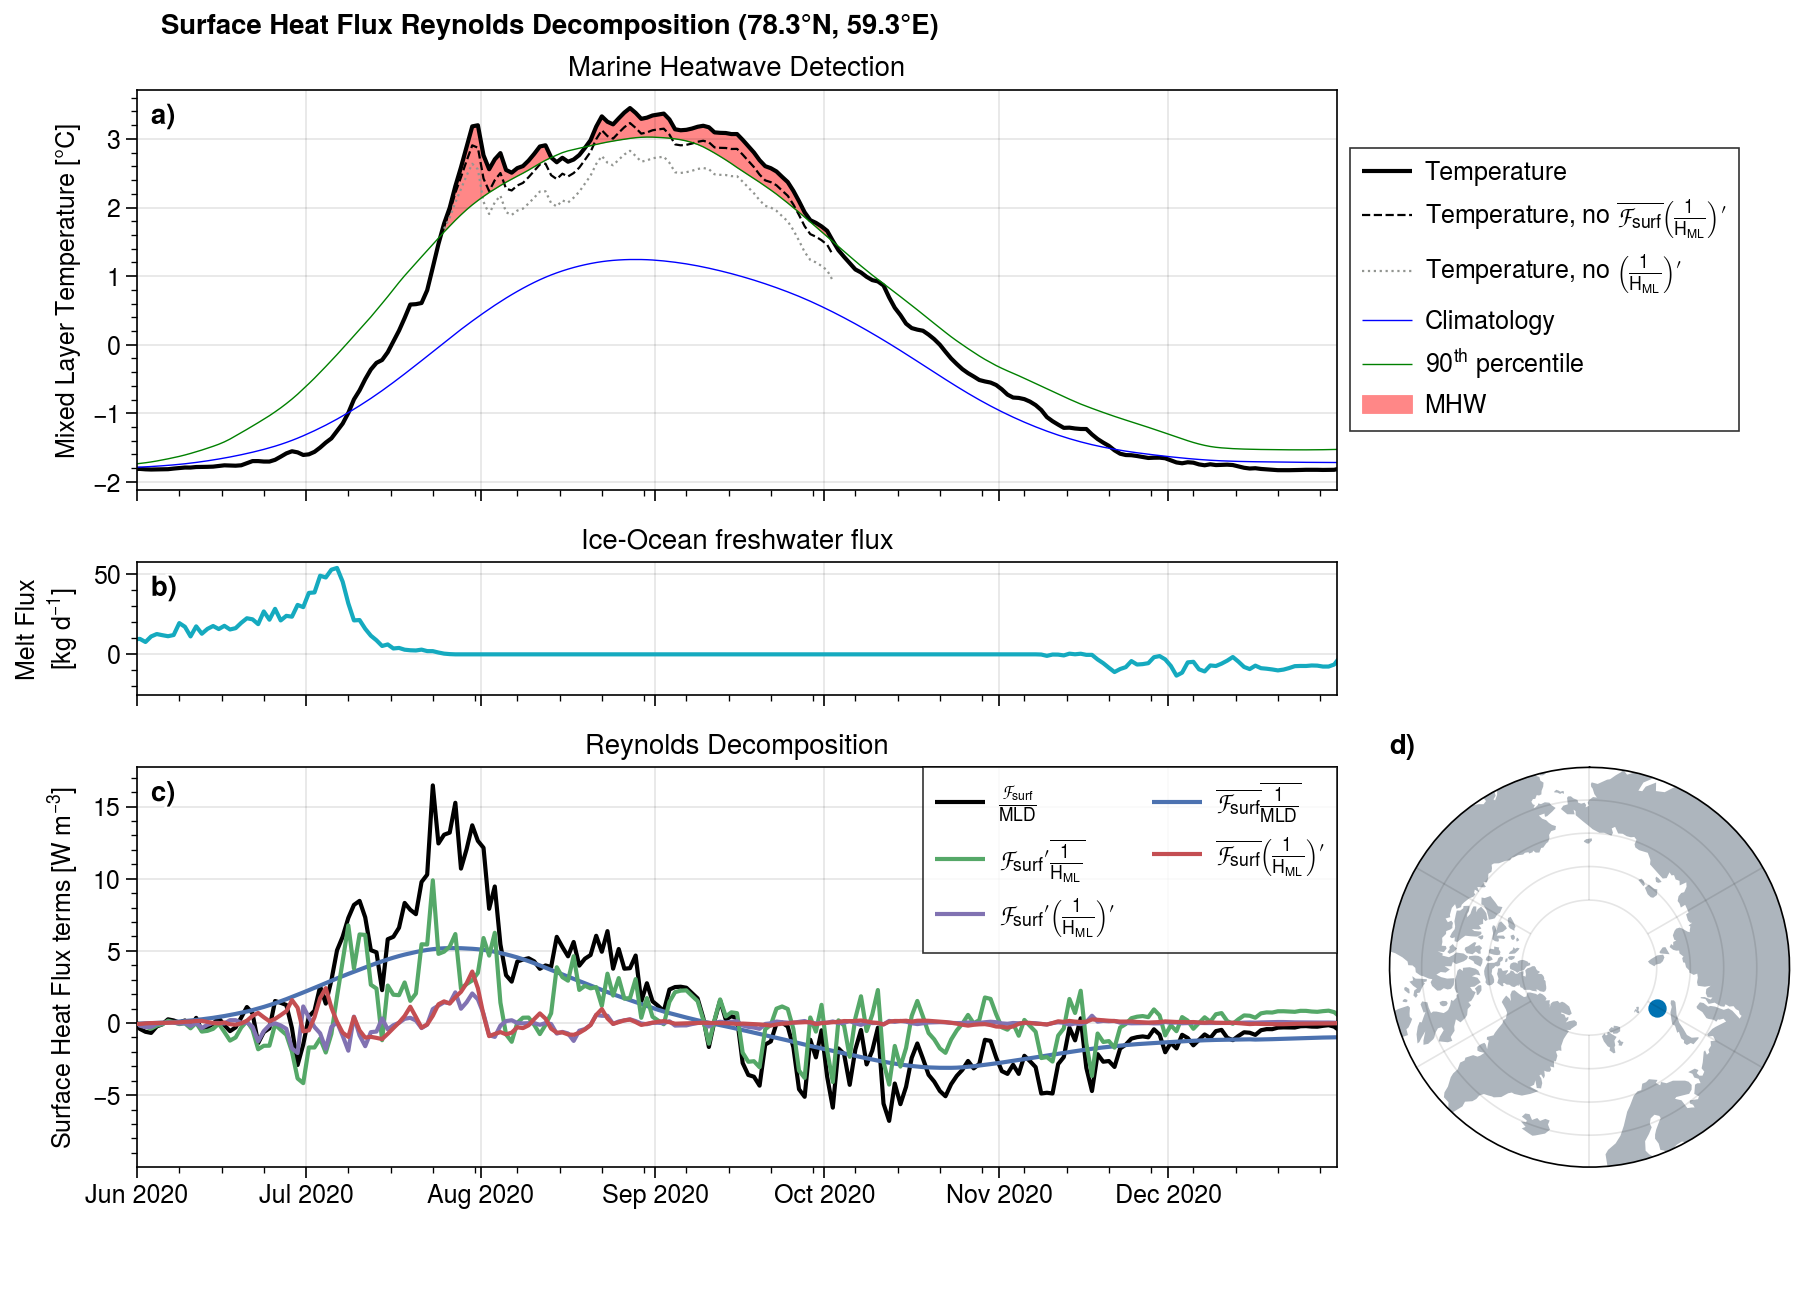

In [26]:
# Now let's plot it all:
yy='2020'
fig = pplt.figure(axwidth=6,axheight=2,sharey=0, sharex=3)
axs = fig.subplots([[1,1,1,4],[2,2,2,5],[3,3,3,6]],hratios=(3,1,3))
# First panel: MLT, MLT without shoaling impact, climatology, threshold, MHW.
h0=axs[0].plot(ds_MLT.toce.isel(tiles=tt),c='k',label='Temperature')
h5=axs[0].plot(MLT_1_noShoal1,c='k',ls='--',lw=0.8,
               label=r'Temperature, no $\overline{\mathcal{F}_{surf}}\left(\frac{1}{H_{ML}}\right)\prime$')
h6=axs[0].plot(MLT_1_noShoal2,c='grey',ls=':',lw=0.8,label=r'Temperature, no $\left(\frac{1}{H_{ML}}\right)\prime$')
h1=axs[0].plot(ds_clims.seas.isel(tiles=tt),c='b',lw=0.5, label='Climatology')
h2=axs[0].plot(ds_clims.thresh.isel(tiles=tt),c='g',lw=0.5, label='90$^{th}$ percentile')
h3,h4=axs[0].area(ds_MLT.time,ds_clims.thresh.isel(tiles=tt),ds_MLT.toce.isel(tiles=tt),
            negpos=True, negcolor='w',poscolor='red4',label='MHW')
axs[0].legend([h0,h5,h6,h1,h2,h4],ncol=1,loc='r')
axs[0].format(ylabel='Mixed Layer Temperature [°C]',
              title='Marine Heatwave Detection',
              suptitle="Surface Heat Flux Reynolds Decomposition ({0:.1f}°N, {1:.1f}°E){2}".format(
                  ds_MLD_tiles.isel(tiles=tt).latitude.values, 
                  ds_MLD_tiles.isel(tiles=tt).longitude.values,
                  "                                                 ")
             )
# Second panel: FM flux
axs[1].plot(-ds_Ice.fmmflx.isel(tiles=tt), c='cyan6',ls='-')
axs[1].format(ylabel='Melt Flux\n[kg d$^{-1}$]',
              title='Ice-Ocean freshwater flux'
             )
# Third panel: Reynolds decomposition terms.
cyc = pplt.Cycle('seaborn')
hs4=axs[2].plot(ds_QovrH_rey.QovrH.isel(tiles=tt),c='k',ls='-',
                label=r'$\frac{\mathcal{F}_{surf}}{MLD}}$')
hs0=axs[2].plot(ds_QovrH_rey.Qbar_1ovrHbar.isel(tiles=tt),
                cycle='seaborn',
                label=r'$\overline{\mathcal{F}_{surf}}\overline{\frac{1}{MLD}}$')
hs1=axs[2].plot(ds_QovrH_rey.Qprime_1ovrHbar.isel(tiles=tt),
                label=r"$\mathcal{F}_{surf}\prime \overline{\frac{1}{H_{ML}}}$")
hs2=axs[2].plot(ds_QovrH_rey.Qbar_1ovrHprime.isel(tiles=tt),zorder=10,
                label=r"$\overline{\mathcal{F}_{surf}}\left(\frac{1}{H_{ML}}\right)\prime$")
hs3=axs[2].plot(ds_QovrH_rey.Qprime_1ovrHprime.isel(tiles=tt),
                label=r"$\mathcal{F}_{surf}\prime \left(\frac{1}{H_{ML}}\right)\prime$")
axs[2].legend([hs4,hs0,hs1,hs2,hs3], ncol=2)
axs[2].format(xrotation=0, xformatter='%b %Y',
              xlim=[np.datetime64(yy+'-06'),np.datetime64(yy+'-12-31')],
              ylabel='Surface Heat Flux terms [W m$^{-3}$]',
              xlabel='',
              title='Reynolds Decomposition'
             )
# Formatting
axs.format(abc='a)',abcloc='ul')
axs[3:6].set_visible(False)
# Fourth panel: Map of location of tile
proj=pplt.Proj('nplaea')
ax_end = fig.subplot(3,4,(12), projection=proj,abc='a)',number=4)
ax_end.scatter(ds_MLD_tiles.isel(tiles=tt).longitude.values,ds_MLD_tiles.isel(tiles=tt).latitude.values,)
ax_end.format(boundinglat=60, land=True, landcolor='grey5',)
# fig.save(path2figs.joinpath("Qsurf_ReyDecompo_noShoal_tile{0}_y{1}.png".format(tt,yy)),dpi=400)
# fig.save(path2figs.joinpath("Qsurf_ReyDecompo_noShoal_tile{0}_y{1}.svg".format(tt,yy)))

In [34]:
# Some quantitative stuffs: Duration, intensity
# Durations
Lday_SibHW_ctrl = ds_mhws_filter.isel(tiles=tt,mhw=mhw).duration.compute()
Lday_SibHW_noHprime = (MLT_1_noShoal1>clim_SibHW.thresh).sum()
Lday_SibHW_noFprimeHprime = (MLT_1_noShoal2>clim_SibHW.thresh).sum()
# Intensities relative to Threshold (cumulative and peak)
PkovrThresh = (MLT_SibHW2020_1 - clim_SibHW.thresh)
PkovrThresh1 = (MLT_1_noShoal1 - clim_SibHW.thresh).where(MLT_1_noShoal1 >clim_SibHW.thresh)
PkovrThresh2 = (MLT_1_noShoal2 - clim_SibHW.thresh).where(MLT_1_noShoal2 >clim_SibHW.thresh)
PkovrThresh1.sum().values, PkovrThresh2.sum().values, PkovrThresh1.max().values, PkovrThresh2.max().values
# Little trick if need to calculate consecutive True
# np.argmin(blop[np.argmax(blop):])

(array(8.51000909), array(2.53655287), array(0.86261639), array(0.63052509))

This is very conclusive for now, for this specific event. Let's try to expand this analysis to all MHWs of interest

In [29]:
# Next step is to try to expand this to more MHWs. So need to automatize it! tricky...
# First, select rank drivers for all MHW driven by surface (again). 
# Also restrain to MHWs where the shoaling has a positive impact. Try Onset and Decay: similar results.
Bool_Qsr1 = xr.Dataset.from_dataframe(df_rankDrv1_Onset).Qsr_net_top == 1
Bool_PosHprime = ds_QovrH_mhw.Qbar_1ovrHprime.sel(trend='Decay') >= 0
# Convert terms to °C day-1
QovrH_rey_inC = ds_QovrH_rey / (rho* cp) * 86400
Qpr_1ovrHpr_pr_inC = Qprime_1overHprime_prime / (rho* cp) * 86400
# Do the actual filter
ds_mhws_filter_Qsr = ds_mhws_filter.where(Bool_Qsr1 * Bool_PosHprime).dropna(dim='mhw',how='all')
# Initialize empty dict and datasets to store results.
tempdict1 = {}
tempdict2 = {}
L_noShoal1 = xr.zeros_like(ds_mhws_filter_Qsr.duration)
L_noShoal2 = xr.zeros_like(ds_mhws_filter_Qsr.duration)
PeakInt_noShoal1 = xr.zeros_like(ds_mhws_filter_Qsr.duration)
PeakInt_noShoal2 = xr.zeros_like(ds_mhws_filter_Qsr.duration)
CumulInt_noShoal1 = xr.zeros_like(ds_mhws_filter_Qsr.duration)
CumulInt_noShoal2 = xr.zeros_like(ds_mhws_filter_Qsr.duration)
MeanInt_noShoal1 = xr.zeros_like(ds_mhws_filter_Qsr.duration)
MeanInt_noShoal2 = xr.zeros_like(ds_mhws_filter_Qsr.duration)
# Loop over tiles
for ind,tile in enumerate(ds_mhws_filter_Qsr.tiles):
    # Loop over MHWs
    for ind2, nmhw in enumerate(ds_mhws_filter_Qsr.mhw):
        # To speed up the loop (slow), skip MHWs that are naned out through filtering.
        if ds_mhws_filter_Qsr.sel(tiles=tile,mhw=nmhw).duration.isnull() | ~Bool_Qsr1.sel(tiles=tile,mhw=nmhw).values:
            continue
        # Select start and end dates.
        DateStart = ds_mhws_filter_Qsr.sel(tiles=tile,mhw=nmhw).date_start
        DateEnd = ds_mhws_filter_Qsr.sel(tiles=tile,mhw=nmhw).date_end
        # Select MLT, clim and ReyDec terms over MHW
        MLT_mhw = ds_MLT.sel(tiles=tile,time=slice(DateStart, DateEnd+np.timedelta64(1,'D'))).toce
        clims_mhw = ds_clims.sel(tiles=tile,time=slice(DateStart, DateEnd+np.timedelta64(1,'D')))
        QovrH_mhw = QovrH_rey_inC.sel(tiles=tile,time=slice(DateStart, DateEnd+np.timedelta64(1,'D')))
        QovrH_mhw_int = QovrH_mhw.cumsum() # Cumulative integral
        QovrH_3prime = Qpr_1ovrHpr_pr_inC.sel(tiles=tile,time=slice(DateStart, DateEnd+np.timedelta64(1,'D')))
        QovrH_3prime_int = QovrH_3prime.cumsum()
        # Remove the contribution of the shoaling from the MLT
        MLT_noShoal1 = MLT_mhw - QovrH_mhw_int.Qbar_1ovrHprime
        MLT_noShoal2 = MLT_mhw - QovrH_mhw_int.Qbar_1ovrHprime - QovrH_3prime_int
        # Get anomalies (relThresh) without the shoaling (both methods)
        AnomMLT_noShoal1_mhw = (MLT_noShoal1 - clims_mhw.thresh).where(MLT_noShoal1 > clims_mhw.thresh)
        AnomMLT_noShoal2_mhw = (MLT_noShoal2 - clims_mhw.thresh).where(MLT_noShoal2 > clims_mhw.thresh)
        # Finally get metrics:
        # Ddurations
        L_noShoal1.loc[dict(tiles=tile, mhw=nmhw)] = AnomMLT_noShoal1_mhw.count().values
        L_noShoal2.loc[dict(tiles=tile, mhw=nmhw)] = AnomMLT_noShoal2_mhw.count().values
        # Peak intensity
        PeakInt_noShoal1.loc[dict(tiles=tile, mhw=nmhw)] = AnomMLT_noShoal1_mhw.max().values
        PeakInt_noShoal2.loc[dict(tiles=tile, mhw=nmhw)] = AnomMLT_noShoal2_mhw.max().values
        # Cumulative intensity
        CumulInt_noShoal1.loc[dict(tiles=tile, mhw=nmhw)] = AnomMLT_noShoal1_mhw.sum().values
        CumulInt_noShoal2.loc[dict(tiles=tile, mhw=nmhw)] = AnomMLT_noShoal2_mhw.sum().values
        # Mean intensity
        MeanInt_noShoal1.loc[dict(tiles=tile, mhw=nmhw)] = AnomMLT_noShoal1_mhw.mean().values
        MeanInt_noShoal2.loc[dict(tiles=tile, mhw=nmhw)] = AnomMLT_noShoal2_mhw.mean().values

In [30]:
# Last step: need to turn the 0s into nans, to be able to compare
L_noShoal1 = L_noShoal1.where(Bool_Qsr1*Bool_PosHprime)
L_noShoal2 = L_noShoal2.where(Bool_Qsr1*Bool_PosHprime)
PeakInt_noShoal1 = PeakInt_noShoal1.where(Bool_Qsr1*Bool_PosHprime)
PeakInt_noShoal2 = PeakInt_noShoal2.where(Bool_Qsr1*Bool_PosHprime)
CumulInt_noShoal1 = CumulInt_noShoal1.where(Bool_Qsr1*Bool_PosHprime)
CumulInt_noShoal2 = CumulInt_noShoal2.where(Bool_Qsr1*Bool_PosHprime)
# For mean intensity, if there is no MHW anymore, we would still want a mean intensity of 0, not just a nan.
# So need an extra `where` statement to replace the 5 MHW with no days at all anymore into a 0
MeanInt_noShoal1 = MeanInt_noShoal1.where(Bool_Qsr1*Bool_PosHprime).where(L_noShoal1!=0,0)
MeanInt_noShoal2 = MeanInt_noShoal2.where(Bool_Qsr1*Bool_PosHprime).where(L_noShoal2!=0,0)

In [40]:
# Now calculate the Difference with the control MHWs:
# Duration change
Delta_Lday1 = ds_mhws_filter_Qsr.duration - L_noShoal1
Delta_Lday2 = ds_mhws_filter_Qsr.duration - L_noShoal2
# Peak intensity change
Delta_PeakInt1 = ds_mhws_filter_Qsr.intensity_max_relThresh - PeakInt_noShoal1
Delta_PeakInt2 = ds_mhws_filter_Qsr.intensity_max_relThresh - PeakInt_noShoal2
# Cumulative intensity change
Delta_CumulInt1 = ds_mhws_filter_Qsr.intensity_cumulative_relThresh - CumulInt_noShoal1
Delta_CumulInt2 = ds_mhws_filter_Qsr.intensity_cumulative_relThresh - CumulInt_noShoal2
# Mean intensity change
Delta_MeanInt1 = ds_mhws_filter_Qsr.intensity_mean_relThresh - MeanInt_noShoal1
Delta_MeanInt2 = ds_mhws_filter_Qsr.intensity_mean_relThresh - MeanInt_noShoal2
# Calculate number of MHWs that are not MHWs anymore
(L_noShoal1 < 5).sum(), (L_noShoal2 < 5).sum()
# Also calculate proportion
(Delta_Lday1/L_noShoal1.where(L_noShoal1)).mean()

In [41]:
#Print the change in percentage, with reference (denominator) being the initial MHWs or the change MHWs
# We will use the first set of numbers in the paper, because more conservative. 
print("Impact 1 on: duration {0:.1%}, Peak {1:.1%}, Cumulative {2:.1%}, Mean {3:.1%}".format(
    (Delta_Lday1/ds_mhws_filter_Qsr.duration).mean(),
    (Delta_PeakInt1/ds_mhws_filter_Qsr.intensity_max_relThresh).mean(),
    (Delta_CumulInt1/ds_mhws_filter_Qsr.intensity_cumulative_relThresh).mean(),
    (Delta_MeanInt1/ds_mhws_filter_Qsr.intensity_mean_relThresh).mean()))
print("Impact 2 on: duration {0:.1%}, Peak {1:.1%}, Cumulative {2:.1%}, Mean {3:.1%}".format(
    (Delta_Lday2/ds_mhws_filter_Qsr.duration).mean(),
    (Delta_PeakInt2/ds_mhws_filter_Qsr.intensity_max_relThresh).mean(),
    (Delta_CumulInt2/ds_mhws_filter_Qsr.intensity_cumulative_relThresh).mean(),
    (Delta_MeanInt2/ds_mhws_filter_Qsr.intensity_mean_relThresh).mean()))

print("Impact 1 on: duration {0:.1%}, Peak {1:.1%}, Cumulative {2:.1%}, Mean {3:.1%}".format(
    (Delta_Lday1/L_noShoal1.where(L_noShoal1)).mean(),
    (Delta_PeakInt1/PeakInt_noShoal1).mean(),
    (Delta_CumulInt1/CumulInt_noShoal1.where(CumulInt_noShoal1)).mean(),
    (Delta_MeanInt1/MeanInt_noShoal1.where(MeanInt_noShoal1)).mean()))
print("Impact 2 on: duration {0:.1%}, Peak {1:.1%}, Cumulative {2:.1%}, Mean {3:.1%}".format(
    (Delta_Lday2/L_noShoal2.where(L_noShoal2)).mean(),
    (Delta_PeakInt2/PeakInt_noShoal2).mean(),
    (Delta_CumulInt2/CumulInt_noShoal2.where(CumulInt_noShoal2)).mean(),
    (Delta_MeanInt2/MeanInt_noShoal2.where(MeanInt_noShoal2)).mean()))

Impact 1 on: duration 18.3%, Peak 1.1%, Cumulative 29.1%, Mean 19.1%
Impact 2 on: duration 24.8%, Peak 4.6%, Cumulative 30.9%, Mean 18.6%
Impact 1 on: duration 52.2%, Peak 70.2%, Cumulative 387.1%, Mean 63.8%
Impact 2 on: duration 81.2%, Peak 94.8%, Cumulative 440.9%, Mean 86.5%


Text(0.5, 0.98, 'Impact of Shoaling on MHW durations')

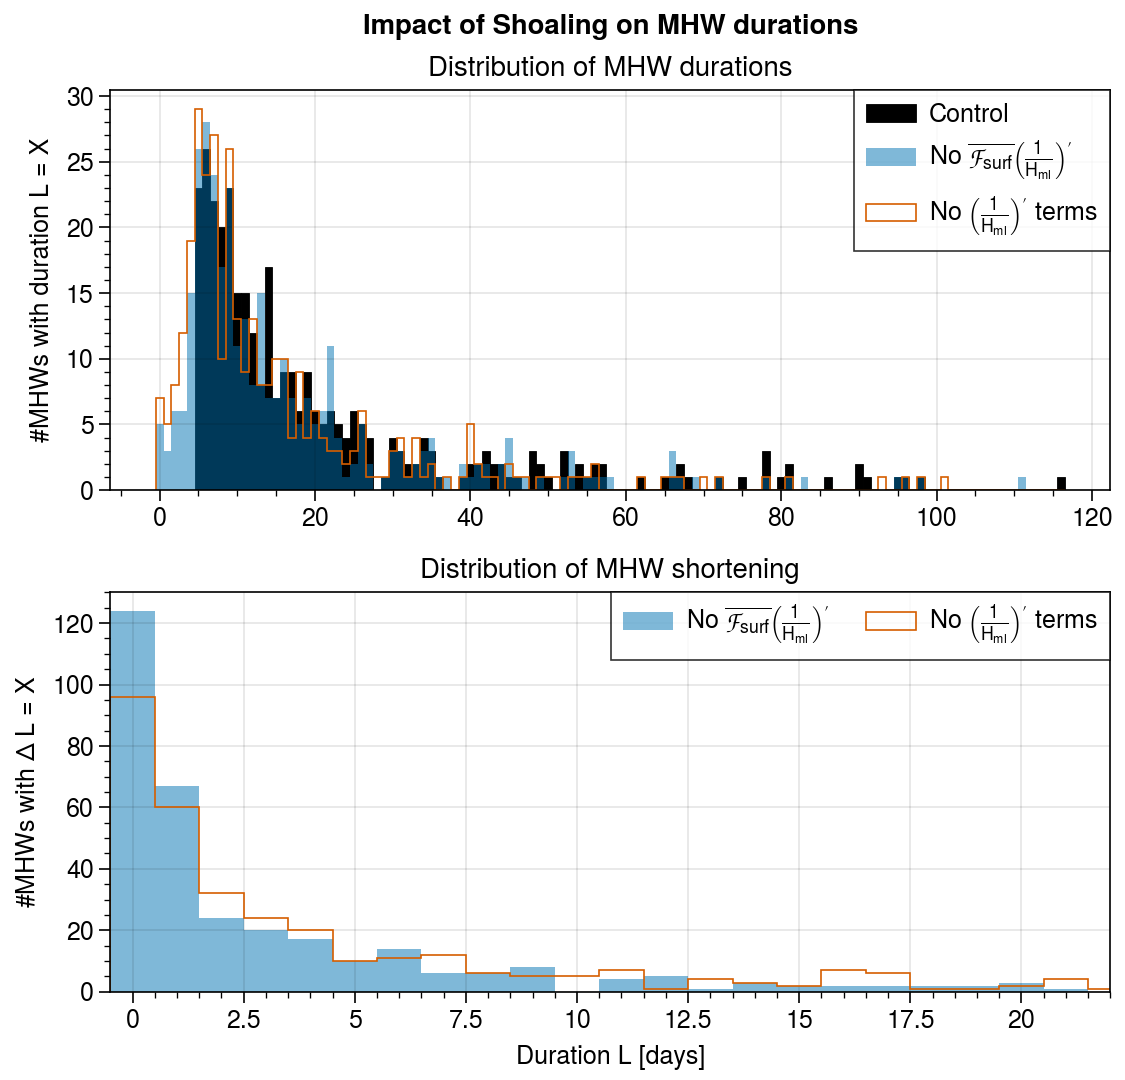

In [34]:
# Plot distributions to see the impact.
fig, axs = pplt.subplots(nrows=2,axwidth=5,axheight=2,sharex=1,sharey=0)
_ = axs[0].hist(ds_mhws_filter_Qsr.duration.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,117.5),
                c='k',label='Control')
_ = axs[0].hist(L_noShoal1.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,117.5),alpha=0.5,
                label=r'No $\overline{\mathcal{F}_{surf}} \left(\frac{1}{H_{ml}}\right)^\prime$')
_ = axs[0].hist(L_noShoal2.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,117.5),fill=False,
                label=r'No $\left(\frac{1}{H_{ml}}\right)^\prime$ terms')
axs[0].legend(ncols=1)
axs[0].format(ylabel='#MHWs with duration L = X',title='Distribution of MHW durations')
_ = axs[1].hist(Delta_Lday1.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,50.5),alpha=0.5,
                label=r'No $\overline{\mathcal{F}_{surf}} \left(\frac{1}{H_{ml}}\right)^\prime$')
_ = axs[1].hist(Delta_Lday2.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,50.5),fill=False
                ,label=r'No $\left(\frac{1}{H_{ml}}\right)^\prime$ terms')
axs[1].format(xlim=[-0.5,22],ylabel='#MHWs with $\Delta$ L = X',title='Distribution of MHW shortening')
axs[1].legend()
axs.format(xlabel='Duration L [days]')
fig.suptitle('Impact of Shoaling on MHW durations')

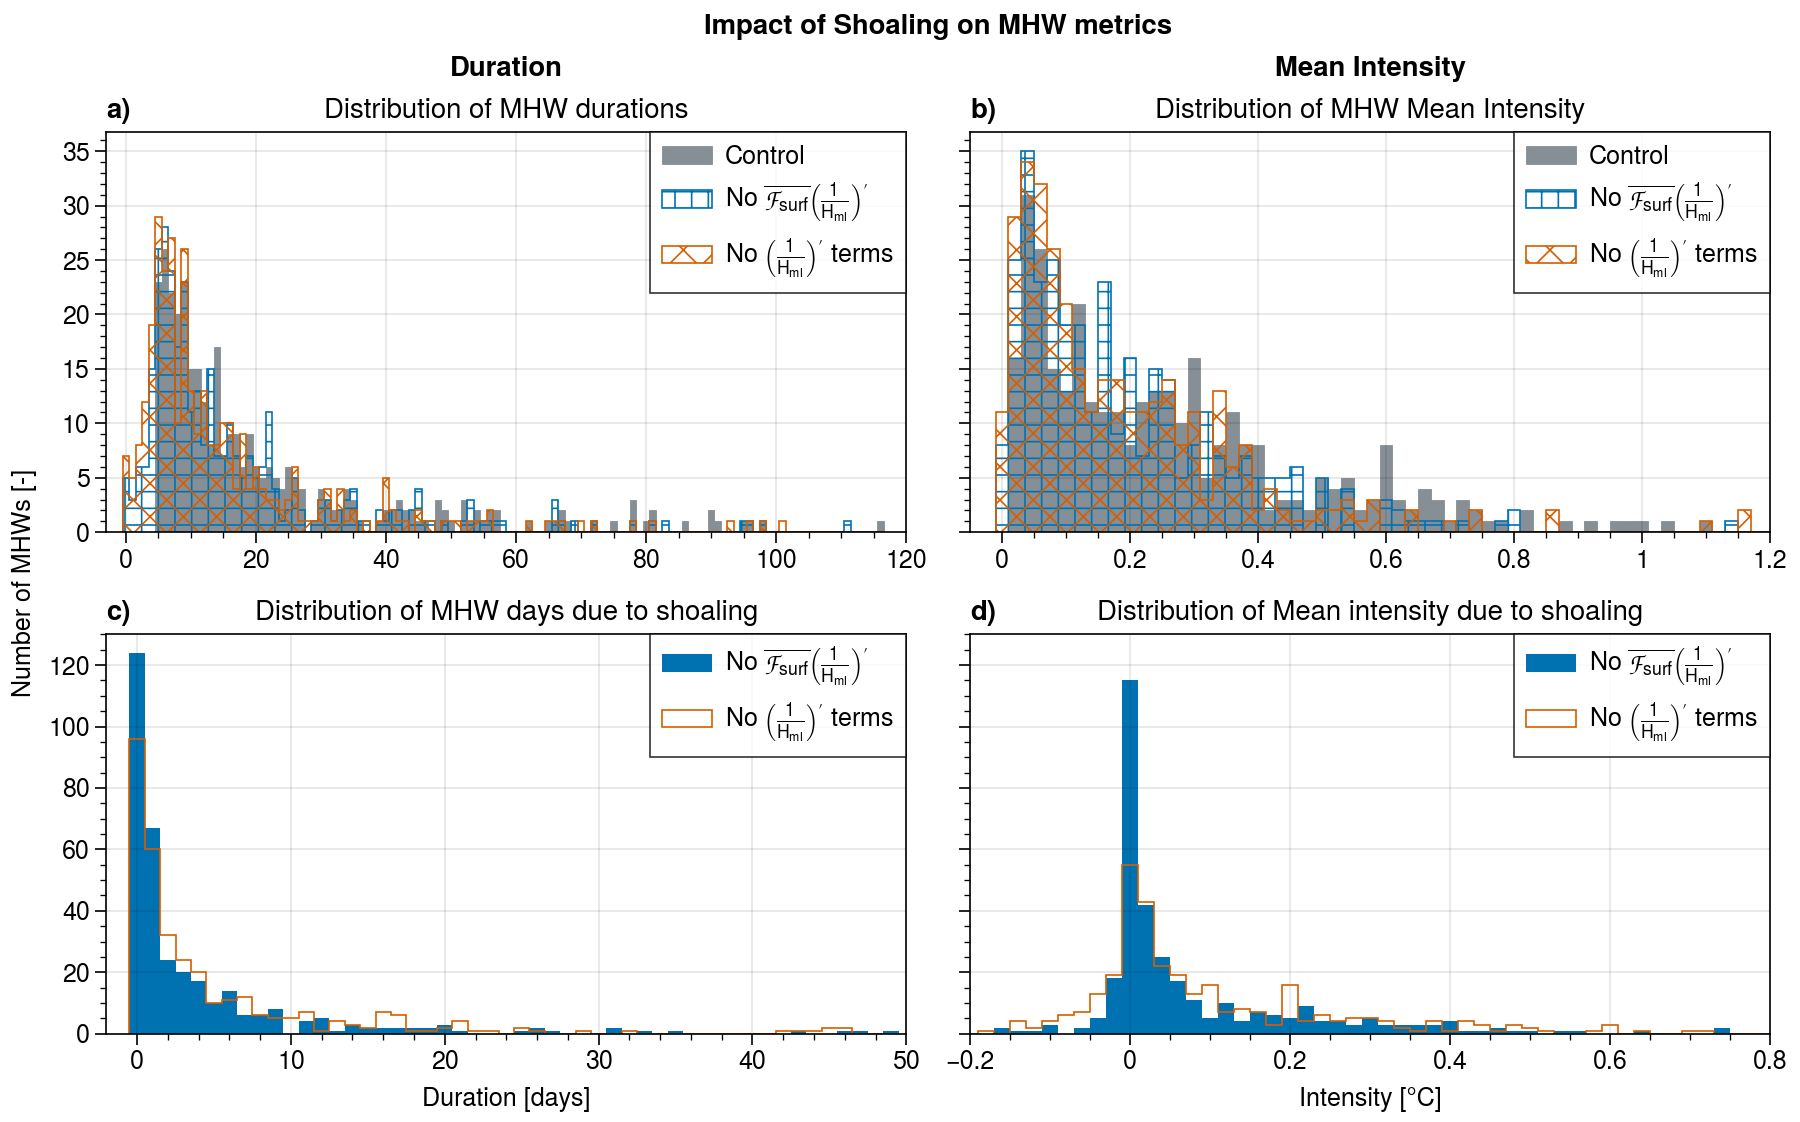

In [81]:
# More complex and thorough histogram plots, for supplementary materials.
fig, axs = pplt.subplots(nrows=2,ncols=2,axwidth=4,axheight=2,sharex=0, abc='a)')
# For Durations
_ = axs[0].hist(ds_mhws_filter_Qsr.duration.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,117,1),
                c='grey6',label='Control')
_ = axs[0].hist(L_noShoal1.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,117,1),alpha=1.0,fill=False,hatch='++',
                label=r'No $\overline{\mathcal{F}_{surf}} \left(\frac{1}{H_{ml}}\right)^\prime$')
_ = axs[0].hist(L_noShoal2.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,117,1),fill=False,hatch='xx',
                label=r'No $\left(\frac{1}{H_{ml}}\right)^\prime$ terms')
axs[0].legend(ncols=1)
axs[0].format(xlim=[-3,120],xlabel='',ylabel='Number of MHWs [-]',title='Distribution of MHW durations')
_ = axs[2].hist(Delta_Lday1.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,50.5),alpha=1.0,fill=True,
                label=r'No $\overline{\mathcal{F}_{surf}} \left(\frac{1}{H_{ml}}\right)^\prime$')
_ = axs[2].hist(Delta_Lday2.stack(blop=['tiles','mhw']),bins=np.arange(-0.5,50.5),fill=False
                ,label=r'No $\left(\frac{1}{H_{ml}}\right)^\prime$ terms')
axs[2].format(xlim=[-2,50],xlabel='Duration [days]',ylabel='Number of MHWs [-]',
              title='Distribution of MHW days due to shoaling')
axs[2].legend(ncols=1)

# For Mean intensity
_ = axs[1].hist(ds_mhws_filter_Qsr.intensity_mean_relThresh.stack(blop=['tiles','mhw']),bins=np.arange(-0.01,1.5,0.02),
                c='grey6',label='Control')
_ = axs[1].hist(MeanInt_noShoal1.stack(blop=['tiles','mhw']),bins=np.arange(-0.01,1.5,0.02),alpha=1.0,fill=False,hatch='++',
                label=r'No $\overline{\mathcal{F}_{surf}} \left(\frac{1}{H_{ml}}\right)^\prime$')
_ = axs[1].hist(MeanInt_noShoal2.stack(blop=['tiles','mhw']),bins=np.arange(-0.01,1.5,0.02),fill=False,hatch='xx',
                label=r'No $\left(\frac{1}{H_{ml}}\right)^\prime$ terms')
axs[1].legend(ncols=1)
axs[1].format(xlim=[-0.05,1.2],xlabel='',ylabel='Number of MHWs [-]',title='Distribution of MHW Mean Intensity')
_ = axs[3].hist(Delta_MeanInt1.stack(blop=['tiles','mhw']),bins=np.arange(-1.51,2.025,0.02),alpha=1.0,fill=True,
                label=r'No $\overline{\mathcal{F}_{surf}} \left(\frac{1}{H_{ml}}\right)^\prime$')
_ = axs[3].hist(Delta_MeanInt2.stack(blop=['tiles','mhw']),bins=np.arange(-1.51,2.025,0.02),fill=False,
                label=r'No $\left(\frac{1}{H_{ml}}\right)^\prime$ terms')
axs[3].format(xlim=[-0.2,0.8],xlabel='Intensity [°C]',ylabel='Number of MHWs [-]',
              title='Distribution of Mean intensity due to shoaling')
axs[3].legend(ncols=1)
# Some formatting
axs.format(toplabels=['Duration','Mean Intensity'])
fig.suptitle('Impact of Shoaling on MHW metrics')
# fig.save(path2figs.joinpath("SuppFig_Distrib_MHWstats_noShoaling.png"),dpi=400)
# fig.save(path2figs.joinpath("SuppFig_Distrib_MHWstats_noShoaling.svg"))